In [2]:
from prog_models.models import BatteryCircuit
import pandas as pd
import os
import random
import warnings
from sklearn import tree, linear_model, kernel_ridge, svm, neighbors, gaussian_process, ensemble, neural_network
from sklearn.model_selection import cross_validate
import pickle
import numpy as np


# Suppress ProgModelStateLimitWarning warnings
warnings.filterwarnings("ignore")

In [11]:
# Use prog_models package for simulation of health
def produce_model(machine, states, load, time=100): 
        
        # Define load of battery
        def future_loading(t, x=None):
            return {'i': load}

        # Set current state of machine
        machine.parameters['x0'] = states
        # Simulate 'time' steps
        options = {
            'save_freq': time,  # Frequency at which results are saved
            'dt': 2  # Timestep
        }
        (_, _, states, outputs, event_states) = machine.simulate_to(time, future_loading, **options)
        health = event_states[-1]['EOD']
        return(health, states[-1])

battery = BatteryCircuit()
# Saves initial states of machine, e.g., {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0} for Battery
states = battery.default_parameters['x0']

# Generate Data

In [12]:
### DATA-DRIVEN DEGRADATION ESTIMATION PER ORDER ###
### GENERATE DATA ###
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit  # Import GroupShuffleSplit


script_directory = os.path.dirname(os.path.abspath("__file__"))
battery = BatteryCircuit()
states = battery.default_parameters['x0']
time = 0
dataset = []
old_health = 1
shock = 0
shockProb = 0.05
shockImpactMulti = 5

def random_true(probability):
    return random.random() < probability

for i in range(int(2e5)):
    # Increment reset_counter
    time = time + 1
    load = random.uniform(0, 0.8)
    load_time = random.uniform(0, 1020)
    # Increase wear when degraded
    adj_load_time = load_time * (2 ** (1-old_health))
    # Shock
    adj_load_time = (adj_load_time + ((shockImpactMulti - 1) * adj_load_time * (1 if random_true(shockProb) else 0)))

    # Compute new health, states, t, and v using last battery state and a random new load
    new_health, states = produce_model(machine=battery, states=states, load=load, time=adj_load_time)
    
    if new_health <= 0:
        # Reset battery states to initialize battery for next produce_model call
        states = battery.default_parameters['x0']
        # Sometimes produce_model returns weird or negative values as the end of life is exceeded
        # Here, we just simply set it to zero to not confuse a later learner 
        new_health = 0
        # append to list
        dataset.append([time, old_health, load, load_time, new_health, old_health-new_health, 1])
        #print(time, old_health, load, load_time, new_health, old_health-new_health)
        time = 0
        old_health = 1
    else:
        # append to list
        dataset.append([time, old_health, load, load_time, new_health, old_health-new_health, 0])
        #print(time, old_health, load, load_time, new_health, old_health-new_health)
        old_health = new_health
    
        

# Transform two-dim list to dataframe
dataset = pd.DataFrame(dataset, columns=['time', 'old_health', 'load', 'load_time', 'new_health', 'degradation', 'failed'])
# Denote machine runs to-failure with incrementing id
k = 0
for i in range(dataset.shape[0]):
    if (dataset.iloc[i]['time'] == 1):
        k = k + 1
    dataset.loc[i, 'ID'] = k
dataset = dataset.sort_values(['ID', 'time'], ascending=[True, True])

# Specify the column to be used for grouping (in this case, 'ID')
group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Extract features and target variable
X = dataset[['time', 'old_health', 'load', 'load_time', 'new_health', 'failed']]
y = dataset['degradation']

# Use GroupShuffleSplit to split the data based on 'ID'
for train_index, test_index in group_splitter.split(X, y, groups=dataset['ID']):
    train_data = dataset.iloc[train_index]
    test_data = dataset.iloc[test_index]

# Save it as pickle
script_directory = os.path.dirname(os.path.abspath("__file__"))
train_path = os.path.join(script_directory, 'order_prognostics_x2_train')
test_path = os.path.join(script_directory, 'order_prognostics_x2_test')
train_data.to_pickle(train_path)
test_data.to_pickle(test_path)

# Tune and Save Best Classifier

In [1]:
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pickle

# Load your dataset
script_directory = os.path.dirname(os.path.abspath("__file__"))
train_path = os.path.join(script_directory, 'order_prognostics_x2_train')
train = pd.read_pickle(train_path)
#train = train.head(500)  # Reduce data for faster training (testing)

# Separate features (X) and target variable (y)
X_train = train[['old_health', 'load', 'load_time']]
y_train = train['failed']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the models and hyperparameters to tune
models = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20]
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 5]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 5]
        }
    }
}

# Perform Grid Search with cross-validation for each model with class balancing and custom scoring
results = {}
for model_name, model_info in models.items():
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='recall', cv=5, verbose=2)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    results[model_name] = {'model': best_model, 'score': best_score}
    print(f"Grid Search for {model_name} completed. Best model: {best_model}. Best Score: {best_score}\n")


# Get the best model
best_model_name = max(results, key=lambda k: results[k]['score'])
best_model = results[best_model_name]['model']
print(f'Best Model: {best_model_name}')

# Save the best model to a pickle file
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f'Best model saved to {model_filename}')

Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=  33.0s
[CV] END ....................max_depth=None, n_estimators=50; total time=  32.9s
[CV] END ....................max_depth=None, n_estimators=50; total time=  31.9s
[CV] END ....................max_depth=None, n_estimators=50; total time=  33.0s
[CV] END ....................max_depth=None, n_estimators=50; total time=  32.9s
[CV] END ...................max_depth=None, n_estimators=100; total time= 1.1min
[CV] END ...................max_depth=None, n_estimators=100; total time= 1.1min
[CV] END ...................max_depth=None, n_estimators=100; total time= 1.1min
[CV] END ...................max_depth=None, n_estimators=100; total time= 1.1min
[CV] END ...................max_depth=None, n_estimators=100; total time= 1.1min
[CV] END ...................max_depth=None, n_estimators=150; total time= 1.6

# Test Best Classifier

In [10]:
import os
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

script_directory = os.path.dirname(os.path.abspath("__file__"))
test_path = os.path.join(script_directory, 'order_prognostics_x2_test')
test = pd.read_pickle(test_path)

# Separate features (X) and target variable (y)
X_test = test[['old_health', 'load', 'load_time']]
y_test = test['failed']

noise_sigma = 0.09
# Generate random noise for 'old_health'
noise = np.random.normal(loc=0, scale=noise_sigma, size=len(X_test))
# Add noise to 'old_health'
X_test['old_health'] += np.abs(noise)
# Clip the values to ensure they are between 0 and 1
X_test['old_health'] = np.clip(X_test['old_health'], 0, 1)


# Load the saved model from the pickle file
model_filename = 'best_model.pkl'
with open(model_filename, 'rb') as file:
    model = pickle.load(file)

# Evaluate the best models on the test set and create a DataFrame for the results
print("Evaluating Best Models on Test Data...")
test_results = []
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
model_results = pd.DataFrame({
    'Old_Health': X_test['old_health'],
    'Load': X_test['load'],
    'Load_Time': X_test['load_time'],
    'True_Failed': y_test,
    'Predicted_Failed': y_pred
})
test_results.append((model.__class__.__name__, model_results, accuracy, precision, recall, f1, roc_auc, cm[1, 1], cm[0, 1], cm[0, 0], cm[1, 0]))
print(f'Model {model} tested. Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, f1 score: {f1}, roc_auc: {roc_auc}, Confusion matrix: TP={cm[1, 1]}, FP={cm[0, 1]}, TN={cm[0, 0]}, FN={cm[1, 0]}')


# Create a DataFrame for test results
final_results = pd.DataFrame(columns=['Model', 'Old_Health', 'Load', 'Load_Time', 'True_Failed', 'Predicted_Failed'])
for model.__class__.__name__, model_results, accuracy, precision, recall, f1, roc_auc, tp, fp, tn, fn in test_results:
    model_results['Model'] = model.__class__.__name__
    model_results['accuracy'] = accuracy
    model_results['precision'] = precision
    model_results['recall'] = recall
    model_results['f1'] = f1
    model_results['roc_auc'] = roc_auc
    model_results['tp'] = tp
    model_results['fp'] = fp
    model_results['tn'] = tn
    model_results['fn'] = fn
    final_results = pd.concat([final_results, model_results])

# Specify the Excel file path and name
excel_filename = 'test_results.xlsx'
# Save final_results DataFrame to an Excel file
final_results.to_excel(excel_filename, index=False)
print(f'Test results for best params of each model saved to {excel_filename}')

C:\Users\w_kevi02\AppData\Local\Temp\ipykernel_36788\4185756178.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['old_health'] += np.abs(noise)
C:\Users\w_kevi02\AppData\Local\Temp\ipykernel_36788\4185756178.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['old_health'] = np.clip(X_test['old_health'], 0, 1)


Evaluating Best Models on Test Data...
Model RandomForestClassifier(max_depth=20, n_estimators=150) tested. Accuracy: 0.9620449651995393, Precision: 0.5216191352345906, Recall: 0.7043478260869566, f1 score: 0.5993657505285412, roc_auc: 0.8386082238021133, Confusion matrix: TP=1134, FP=1040, TN=37292, FN=476


C:\Users\w_kevi02\AppData\Local\Temp\ipykernel_36788\4185756178.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, model_results])


Test results for best params of each model saved to test_results.xlsx


# Confusion Matrix

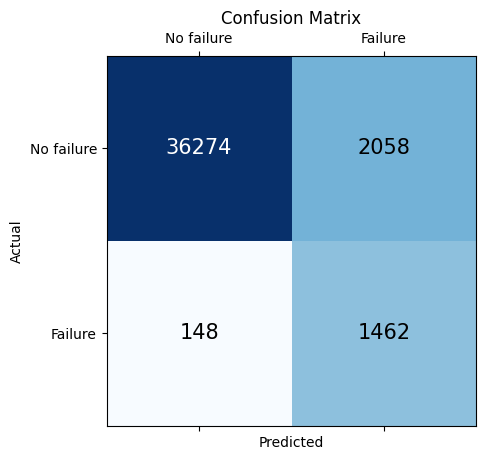

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Confusion matrix values
TP = 1462
FP = 2058
TN = 36274
FN = 148

# Create confusion matrix
conf_matrix = np.array([[TN, FP],
                       [FN, TP]])

# Plotting the confusion matrix with adjusted text color and logarithmic colormap
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues, norm=LogNorm())

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['No failure', 'Failure'])
plt.yticks([0, 1], ['No failure', 'Failure'])

# Display the values on the matrix with adjusted text color
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), va='center', ha='center', color='white' if conf_matrix[i, j] > np.max(conf_matrix) / 2 else 'black', fontsize=15)

plt.show()


# Plot ROC Curve

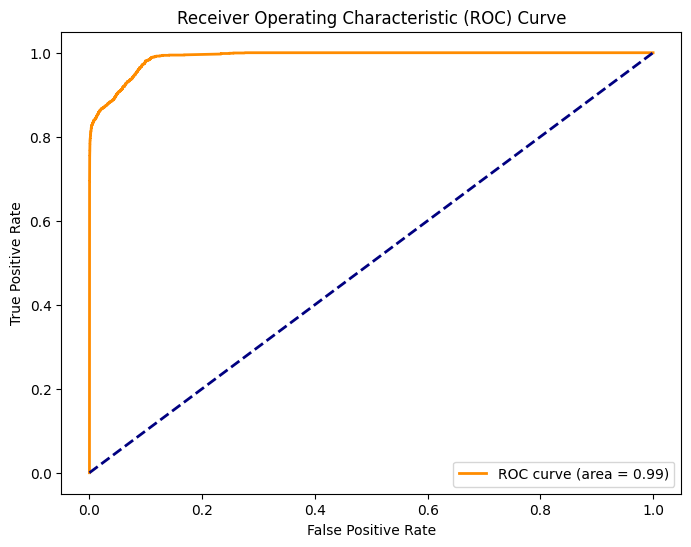

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

script_directory = os.path.dirname(os.path.abspath("__file__"))
test_path = os.path.join(script_directory, 'order_prognostics_x2_test')
test = pd.read_pickle(test_path)

# Separate features (X) and target variable (y)
X_test = test[['old_health', 'load', 'load_time']]
y_test = test['failed']

# Load the saved model from the pickle file
model_filename = 'best_model.pkl'
with open(model_filename, 'rb') as file:
    model = pickle.load(file)

# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
roc_data = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'ROC AUC': roc_auc})

# Save the DataFrame to an Excel file
roc_data.to_excel('roc_curve_data.xlsx', index=False)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Explorative Data Analysis

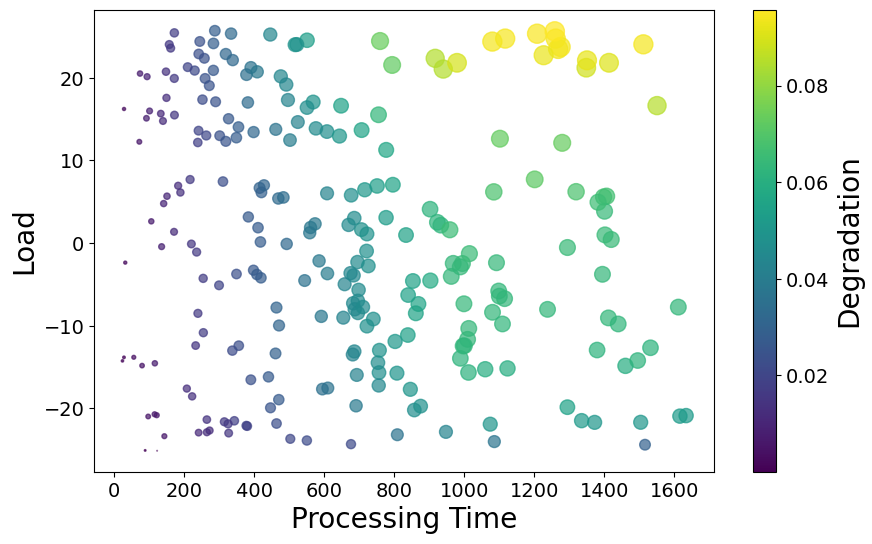

In [48]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Load data from the CSV file and rename columns
order_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'order_data.csv')
order_dataset = pd.read_csv(order_path, encoding='iso-8859-1')
order_dataset = order_dataset[['Durchsatz..kg.h.', 'Runtime', 'Auftragsnummer..None.']]
order_dataset.columns = ['load', 'load_time', 'order']

# Normalize 'load' column to be between 0 and 0.8
scaler = MinMaxScaler(feature_range=(0, 0.8))
order_dataset['load'] = scaler.fit_transform(order_dataset[['load']])

# Convert 'load_time' to minutes
order_dataset['load_time'] = order_dataset['load_time'] / 60

# Load the pre-trained model
model_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'order_prognostics_best_model')
loaded_model = pickle.load(open(model_path, 'rb'))

# Prepare features for prediction
X = order_dataset[['load', 'load_time']]

# Make predictions using the trained model
y_pred = loaded_model.predict(X)

# Append predictions as a new column to the dataset
order_dataset['degradation'] = y_pred

# Save the dataset with predictions as an xlsx file
output_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'bk_order_prediction.xlsx')
order_dataset.to_excel(output_path, index=False)



# Perform t-SNE with one dimension on the 'load' column
tsne = TSNE(n_components=1, random_state=42)
tsne_values = tsne.fit_transform(order_dataset[['load']])

# Add t-SNE values as a new column to the dataset
# Reverse the direction of t-SNE load values
order_dataset['tsne_load'] = tsne_values * -1

# Save the updated dataset with t-SNE values as an xlsx file
output_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'bk_order_prediction_with_tsne.xlsx')
order_dataset.to_excel(output_path, index=False)

# Set the scaling factor for the bubble size
scaling_factor = 2000

# Create a ScalarMappable for colormap
norm = Normalize(vmin=order_dataset['degradation'].min(), vmax=order_dataset['degradation'].max())
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # empty array for the data range

# Plot the bubble chart with specified size and color
plt.figure(figsize=(10, 6))
plt.scatter(order_dataset['load_time'], order_dataset['tsne_load'],
            s=order_dataset['degradation'] * scaling_factor, c=order_dataset['degradation'], cmap='viridis', alpha=0.7)

# Set labels and title
plt.xlabel('Processing Time')
plt.ylabel('Load')

# Add colorbar
plt.colorbar(sm, label='Degradation')

# Show the plot
plt.show()



# OUTDATED

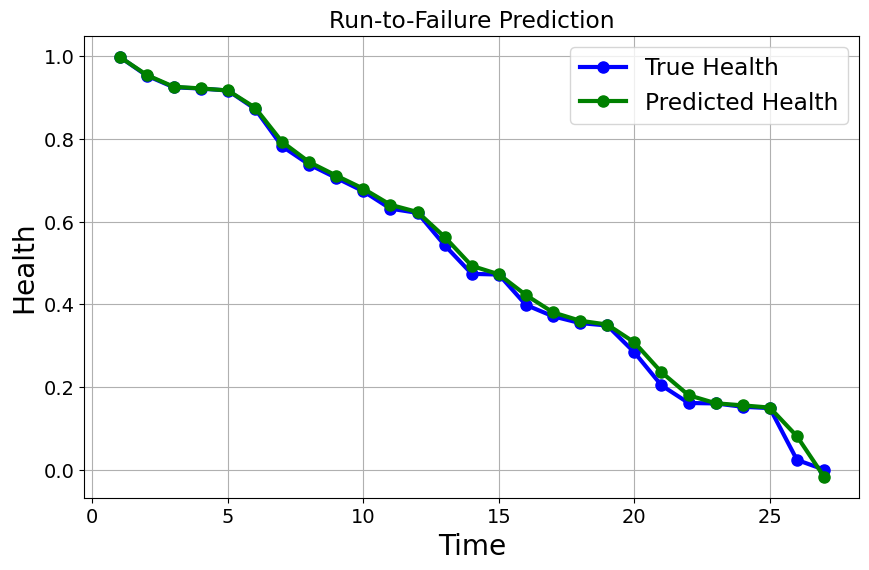

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved dataframe
script_directory = os.path.dirname(os.path.abspath("__file__"))
# Load the data from the pickle file
xlsx_path = os.path.join(script_directory, 'degradation_prediction.xlsx')
order_dataset = pd.read_excel(xlsx_path)

# Filter data for ID == 1
filtered_data = order_dataset[order_dataset['ID'] == 2]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['time'], filtered_data['new_health'], label='True Health', color='blue', marker='o')
plt.plot(filtered_data['time'], filtered_data['health_pred'], label='Predicted Health', color='green', marker='o')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Health')
plt.title('Run-to-Failure Prediction')
plt.legend()
plt.grid(True)
plt.show()


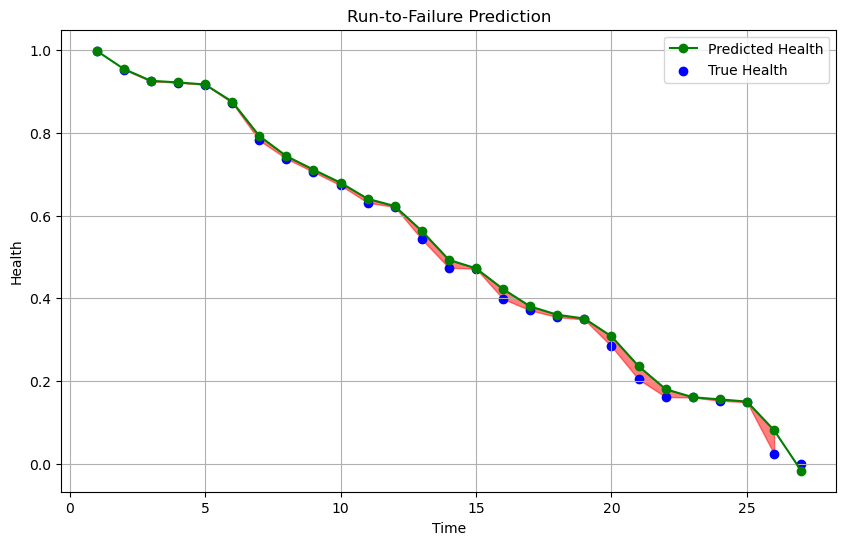

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved dataframe
script_directory = os.path.dirname(os.path.abspath("__file__"))
# Load the data from the pickle file
xlsx_path = os.path.join(script_directory, 'degradation_prediction.xlsx')
order_dataset = pd.read_excel(xlsx_path)

# Filter data for ID == 1
filtered_data = order_dataset[order_dataset['ID'] == 2]

# Calculate the difference between health_pred and new_health
difference = filtered_data['new_health'] - filtered_data['health_pred']

# Plotting
plt.figure(figsize=(10, 6))

# Plot health_pred as a line
plt.plot(filtered_data['time'], filtered_data['health_pred'], label='Predicted Health', color='green', marker='o')

# Create candlestick chart for the difference
plt.fill_between(filtered_data['time'], filtered_data['health_pred'], filtered_data['health_pred'] + difference, where=(difference > 0), color='green', alpha=0.5)
plt.fill_between(filtered_data['time'], filtered_data['health_pred'], filtered_data['health_pred'] + difference, where=(difference <= 0), color='red', alpha=0.5)

# Plot new_health as markers
plt.scatter(filtered_data['time'], filtered_data['new_health'], label='True Health', color='blue', marker='o')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Health')
plt.title('Run-to-Failure Prediction')
plt.legend()
plt.grid(True)
plt.show()


## Regression (OUTDATED)

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
import numpy as np
import pickle

# Load your dataset and reduce it to 1000 observations
script_directory = os.path.dirname(os.path.abspath("__file__"))
train_path = os.path.join(script_directory, 'order_prognostics_x2_train')
order_dataset = pd.read_pickle(train_path)
#order_dataset = order_dataset.head(1000)  # Reduce data to 1000 observations for testing purposes
X = order_dataset[['old_health', 'load', 'load_time']]
y = order_dataset['degradation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom scoring function that penalizes overestimation more than underestimation
# Based on: Saxena, Abhinav, Jose Celaya, Edward Balaban, Kai Goebel, Bhaskar Saha, Sankalita Saha, and Mark Schwabacher. 2008.
# “Metrics for evaluating performance of prognostic techniques.” In 2008 International Conference on Prognostics and Health Management, PHM 2008, 1-17.
# "Exponentially weighs RUL prediction errors through an asymmetric weighting
# function. Penalizes the late predictions more than early predictions."
def asymmetric_mse(y_true, y_pred, alpha=2):
    errors = y_pred - y_true  # Calculate the errors (predicted - true)
    squared_errors = np.where(errors < 0, (alpha * errors) ** 2, errors ** 2)  # Apply asymmetric penalty
    return np.mean(squared_errors)  # Calculate the mean of the squared errors


asymmetric_mse_scorer = make_scorer(asymmetric_mse, greater_is_better=False)

# Define the models and hyperparameters to tune
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 5]
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 5]
        }
    }
}

# Perform Grid Search with cross-validation for each model with verbosity
results = {}
for model_name, model_info in models.items():
    print(f"Performing Grid Search for {model_name}...")
    #grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='r2', cv=5, verbose=2)
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring=asymmetric_mse_scorer, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    results[model_name] = {'model': best_model, 'score': best_score}
    print(f"Grid Search for {model_name} completed. Best Score: {best_score}\n")

# Evaluate the best models on the test set and create a DataFrame for the results
print("Evaluating Best Models on Test Data...")
test_results = []
for model_name, result in results.items():
    model = result['model']
    predicted_values = model.predict(X_test)
    custom_loss_value = asymmetric_mse(y_test, predicted_values)
    r2_score_value = model.score(X_test, y_test)  # Calculate R^2 score
    model_results = pd.DataFrame({
        'Old_Health': X_test['old_health'],
        'Load': X_test['load'],
        'Load_Time': X_test['load_time'],
        'True_Degradation': y_test,
        'Predicted_Degradation': predicted_values
    })
    test_results.append((model_name, model_results, custom_loss_value, r2_score_value))
    print(f'Model: {model_name}, Custom Loss: {custom_loss_value}, R^2 Score: {r2_score_value}')

# Get the best model
best_model_name = min(results, key=lambda k: results[k]['score'])
best_model = results[best_model_name]['model']
print(f'Best Model: {best_model_name}')

# Save the best model to a pickle file
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f'Best model saved to {model_filename}')

# Create a DataFrame for test results
final_results = pd.DataFrame(columns=['Model', 'Old_Health', 'Load', 'Load_Time', 'True_Degradation', 'Predicted_Degradation', 'Custom_Loss', 'R2_Score'])
for model_name, model_results, custom_loss_value, r2_score_value in test_results:
    model_results['Model'] = model_name
    model_results['Custom_Loss'] = custom_loss_value
    model_results['R2_Score'] = r2_score_value
    final_results = pd.concat([final_results, model_results])

# Print the final results DataFrame
print("\nFinal Test Results:")
print(final_results)

# Specify the Excel file path and name
excel_filename = 'final_results.xlsx'

# Save final_results DataFrame to an Excel file
final_results.to_excel(excel_filename, index=False)

print(f'Final results saved to {excel_filename}')

## LOT (OUTDATED)

In [10]:
### DATA-DRIVEN LOAD_TIME ESTIMATION FOR SPECIFIC HEALTH ###
### FIT RANDOMFOREST ###
from sklearn.model_selection import GridSearchCV


order_path = os.path.join(script_directory, 'order_prognostics')
order_dataset = pd.read_pickle(order_path)
X_lot = order_dataset[['load', 'degradation']]
y_lot = order_dataset['load_time']

# Define hyperparameters and their possible values for tuning
#param_grid = {
#    'n_estimators': [50, 100, 150],  # You can adjust these values
#    'max_depth': [None, 10, 20, 30]   # You can adjust these values
#}
#Best Hyperparameters:  {'max_depth': 20, 'n_estimators': 150}
#Best Cross-Validation Score (R2):  0.9528098318212436

# Initialize the RandomForestRegressor
learner_lot = ensemble.RandomForestRegressor(n_estimators=150, max_depth=20)

# Fit the best model on all data
lot_model = learner_lot.fit(X_lot, y_lot)

# Save the best model to a file
pickle.dump(lot_model, open(os.path.join(script_directory, 'lot_prognostics_best_model'), 'wb'))

In [36]:
### CV AND FIT POLYNOMIAL
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import pickle

# Load the data
order_path = os.path.join(script_directory, 'order_prognostics')
order_dataset = pd.read_pickle(order_path)
X = order_dataset[['load', 'degradation']]
y = order_dataset['load_time']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial Regression with hyperparameter tuning
poly_reg = PolynomialFeatures(degree=2)  # You can adjust the degree
linear_reg = LinearRegression()
polynomial_regression = Pipeline([
    ('poly_features', poly_reg),
    ('linear_regression', linear_reg)
])

# Hyperparameter grid for polynomial regression
param_grid = {
    'poly_features__degree': [2, 3, 4, 5, 6, 7, 8]  # Degrees to be considered for polynomial features
}

# Perform cross-validated hyperparameter tuning for Polynomial Regression
grid_search = GridSearchCV(polynomial_regression, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Get the best polynomial regression model
best_polynomial_regression = grid_search.best_estimator_

print("Best Parameters for Polynomial Regression:")
print(grid_search.best_params_)

# Evaluate on test data
y_pred = best_polynomial_regression.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Best Polynomial Regression - R2 Score: {r2:.4f}")

# Save the best polynomial regression model to a file
pickle.dump(best_polynomial_regression, open(os.path.join(script_directory, 'polynomial_regression_lot_best_model.pkl'), 'wb'))

Best Parameters for Polynomial Regression:
{'poly_features__degree': 8}
Best Polynomial Regression - R2 Score: 0.9511
